# DS207 Project - CatBoostRegressor Models
### importing, cleaning, and analyzing data



In [ ]:
import os
import inspect
import csv as csv
import re
import math
import numpy as np
import numpy.linalg as nla
import pandas as pd
import re
import six
from os.path import join
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNetCV, ElasticNet
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures, MinMaxScaler
from sklearn.metrics import (
    log_loss,
    accuracy_score,
    confusion_matrix,
    precision_recall_fscore_support,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    make_scorer,
    classification_report
)

# uncomment out these pip installs and run the cell twice ignoring errors, rerun session when prompted then comment the pip installs out and rerun cell. The catboostregressor should import
!pip install --upgrade numpy
!pip uninstall -y catboost
!pip install catboost
from catboost import CatBoostRegressor


# Configure matplotlib and seaborn
%matplotlib inline
sns.set(style='whitegrid')

print('Libraries imported successfully!')

  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
catboost 1.2.7 requires numpy<2.0,>=1.16.0, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Data Import
data_path = '/content/drive/MyDrive/DS207/pca2.csv'

try:
    data = pd.read_csv(data_path)
    print('Data imported successfully!')
    display(data.head())
except Exception as e:
    print(f'Error importing data: {e}')

Data imported successfully!


,SERIALNO,SPORDER,WAGP,AGEP,COW,SCHL,SEX,WKHP,ESR,NAICSP,RAC1P,HISP,INDP,OCCP,SCIENGP,SCIENGRLP,RACE
0,2023000000009,1,3600,19,1,19,2,16,1,7220,8,2,8680,4055,3,3,0
1,2023000000028,1,800,23,1,19,1,15,1,7115,1,1,8564,2850,3,3,1
2,2023000000052,1,1800,23,1,20,1,15,1,7115,1,1,8564,2850,3,3,1
3,2023000000125,1,65000,28,1,19,1,40,6,4492,9,2,4796,4760,3,3,0
4,2023000000152,1,3000,20,1,19,2,20,6,61101,2,1,7870,4640,3,3,2


In [ ]:
# Check for number of missing values in each columns
missing_values = data.isnull().sum()
print(missing_values)

# Printing shape of data
print(f"The data has {data.shape[0]} rows and {data.shape[1]} columns.")

SERIALNO     0
SPORDER      0
WAGP         0
AGEP         0
COW          0
SCHL         0
SEX          0
WKHP         0
ESR          0
NAICSP       0
RAC1P        0
HISP         0
INDP         0
OCCP         0
SCIENGP      0
SCIENGRLP    0
RACE         0
dtype: int64
The data has 186375 rows and 17 columns.


In [ ]:
# Dictionaries for label mapping
label_mapping_sex = {1:"male", 2:'female'}
label_mapping_cow = {1: 'private for-profit', 2: 'private non-profit', 3: 'local government', 4: 'state government', 5:'federal government', 6:'self employed (non incorp business)', 7:'self employed (incorp business)', 8:"working no pay", 9:"unemployed"}
label_mapping_race = {0:"hispanic",1:"white", 2:'black',3:"american indian", 4:'alaska native', 5:'no other race', 6:'asian', 7:'hawaiian', 8:'some other race', 9:'two or more'}
label_mapping_education = {15:"less than highschool diploma", 19:'highschool diploma',20:"associate's degree", 21:"bachelor's degree", 22:"master's degree", 23:"professional degree beyond bachelor's", 24:'doctorate'}



In [ ]:
# Data Cleaning
def clean_data(df):
    """
    Cleans the input DataFrame by:
      - Dropping duplicate rows
    """
    # Drop duplicate rows
    df = df.drop_duplicates()

    # Rename columns
    df = df.rename(columns={"SERIALNO": "housing_unit", "SPORDER": "person_number", "WAGP":"wage", "AGEP":"age", "COW": "worker_class", "SCHL":"educational_attainment", "SEX": "sex", "WKHP":"num_hours_worked", "ESR":"employment_status", "NAICSP":"industry", "RAC1P":"race_nohispanic", "INDP":"industry_recode", "OCCP":"occupation_recode", "SCIENGP":"dsengin_indicator", "SCIENGRLP":"dsengin_related_indicator", "RACE":"race", "HISP":"hispanic"}, errors="raise")

    # Convert to education, worker_class, sex, employment status, industry, race, race_nohispanic, hispanic, industry_recode, occupation recode, dsengin_indicator and related to categorical
    df['educational_attainment'] = df['educational_attainment'].map(label_mapping_education)
    df['worker_class'] = df['worker_class'].map(label_mapping_cow)
    df['sex'] = df['sex'].map(label_mapping_sex)
    df['educational_attainment_encoded'] = df['educational_attainment'].astype('category').cat.codes.astype(int)
    df['employment_status'] = df['employment_status'].astype('category').cat.codes
    df['industry'] = df['industry'].astype('category').cat.codes
    df['race'] = df['race'].astype('category').cat.codes
    df['race_nohispanic'] = df['race_nohispanic'].astype('category').cat.codes
    df['hispanic'] = df['hispanic'].astype('category').cat.codes
    df['industry_recode'] = df['industry_recode'].astype('category').cat.codes
    df['occupation_recode'] = df['occupation_recode'].astype('category').cat.codes
    df['dsengin_indicator'] = df['dsengin_indicator'].astype('category').cat.codes
    df['dsengin_related_indicator'] = df['dsengin_related_indicator'].astype('category').cat.codes

    # Bin working hours
    df['num_hours_worked_binned'] = pd.cut(df['num_hours_worked'], bins=[0, 30, 45, np.inf], labels=['Part-Time', 'Full-Time', 'Overtime'])

    return df

# Clean the imported data
data = clean_data(data)
data_original = data.copy()
print('Data cleaned successfully!')

Data cleaned successfully!


In [ ]:
data.head()

,housing_unit,person_number,wage,age,worker_class,educational_attainment,sex,num_hours_worked,employment_status,industry,race_nohispanic,hispanic,industry_recode,occupation_recode,dsengin_indicator,dsengin_related_indicator,race,educational_attainment_encoded,num_hours_worked_binned
0,2023000000009,1,3600,19,private for-profit,highschool diploma,female,16,0,167,7,1,231,259,2,2,0,3,Part-Time
1,2023000000028,1,800,23,private for-profit,highschool diploma,male,15,0,163,0,0,225,173,2,2,1,3,Part-Time
2,2023000000052,1,1800,23,private for-profit,associate's degree,male,15,0,163,0,0,225,173,2,2,1,0,Part-Time
3,2023000000125,1,65000,28,private for-profit,highschool diploma,male,40,5,107,8,1,122,299,2,2,0,3,Full-Time
4,2023000000152,1,3000,20,private for-profit,highschool diploma,female,20,5,231,1,0,203,292,2,2,2,3,Part-Time


## Data Split


In [ ]:
# Define target variable and drop from dataset and split data
y = data['wage']
X = data.drop('wage', axis=1)

shuffled_indices = np.random.permutation(len(X))
X = X.iloc[shuffled_indices]
y = y.iloc[shuffled_indices]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1234)


## Baseline Model - Linear Regression to establish baseline

In [ ]:
# One-hot encode categorical features
X_encoded = pd.get_dummies(X, drop_first=True)

# Split the dataset into training and testing sets (80/20 split)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train_lr, y_train_lr)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test_lr)

# Evaluate the model
mse = mean_squared_error(y_test_lr, y_pred_lr)
r2 = r2_score(y_test_lr, y_pred_lr)

print("Linear Regression Baseline")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")

Linear Regression Baseline
Mean Squared Error (MSE): 2610421983.73
R-squared (R²): 0.41


## Using CatBoostRegressor
This model is designed for regression tasks with categorical data to predict a continuous numeric target variable

###Approach #1:
Baseline CatBoostRegressor model with random learning rate, depth and iterations

In [ ]:
%%time
# Define categorical features
cat_columns = ['housing_unit', 'person_number', 'worker_class',
               'educational_attainment', 'sex', 'employment_status', 'industry',
               'race_nohispanic', 'hispanic', 'industry_recode',
               'occupation_recode', 'dsengin_indicator','dsengin_related_indicator',
               'race', 'num_hours_worked_binned']

# Initialize the CatBoostRegressor with learning rate, depth and iterations for baseline
catboost_reg = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=5, random_state=123, verbose=0)

# Train the baseline model
catboost_reg.fit(X_train, y_train, cat_features=cat_columns, eval_set=(X_val, y_val))

# Make baseline predictions
y_val_pred = catboost_reg.predict(X_val)

# Check the mse and r2
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")



Validation Set Mean Squared Error: 1967073347.63
Validation Set R-squared (R²): 0.57


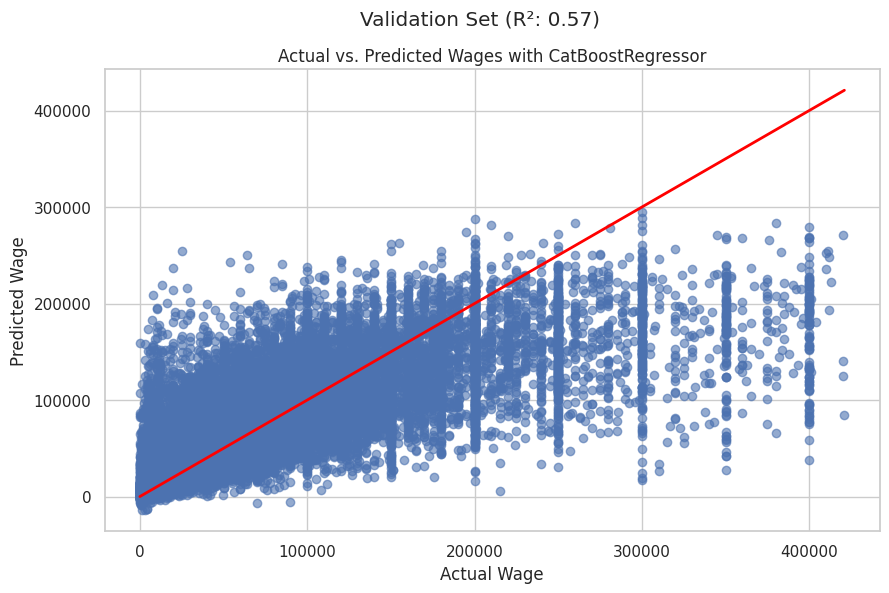

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()

Checking the correlation of features to wage and dropping features with minimal correlation

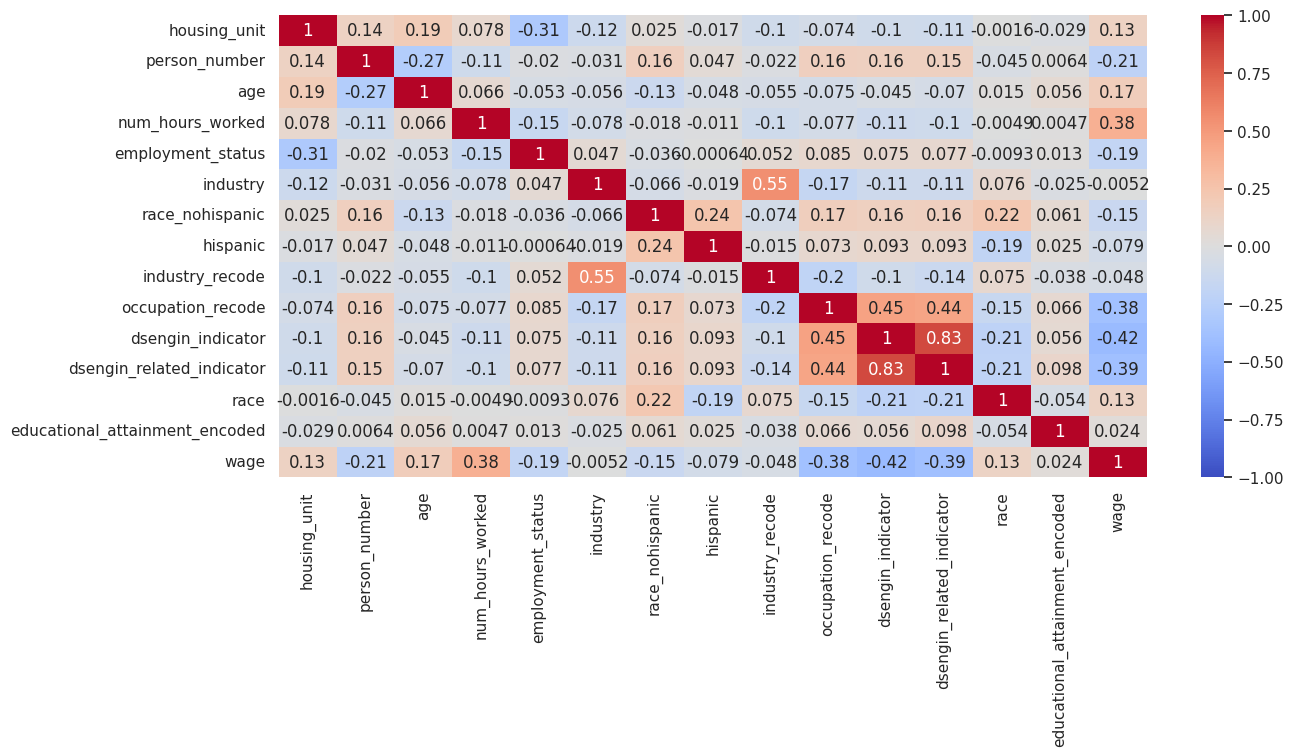

In [ ]:
# printing correlation matrix
df = pd.concat([X_train, y_train], axis = 1)
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()
plt.figure(figsize=(14, 6))
sns.heatmap(corr, annot = True, cmap='coolwarm',vmin=-1, vmax=1)
plt.show()

### Approach #2:
#### Dropping features and additional feature engineering
The correlation plot suggests that the industry and the industry_recode do not have much correlation to wage. Additionally, hispanic, race_nonhispanic and race are all duplicating information. Similarly, there may be duplicate information in the dsengin_indicator and dsengin_related_indicator. I will keep only one of these variables.

Considering feature interactions, there may be interactions between employment_status and num_hours_worked and there may be a non-linear relationship of educational attainment to the model, suggested by the EDA.

I will implement the following changes:
- drop hispanic and race_nonhispanic.
- drop dsengin_related_indicator
- add in employment_status * num_hours_worked
- add in educational_attainment^2

Additionally, it seems like the model is overfitting to the majority class. I have adjusted the learning rate to 0.1, lowered the depth to 4, and lowered the number of iterations to 250.

In [ ]:
%%time
# Apply changes to X_train and X_val
X_train_FE1 = X_train.drop(['hispanic', 'race_nohispanic', 'dsengin_related_indicator'], axis=1)
X_val_FE1 = X_val.drop(['hispanic', 'race_nohispanic', 'dsengin_related_indicator'], axis=1)
X_train_FE1['employment_numhours'] = X_train_FE1['employment_status'] * X_train_FE1['num_hours_worked']
X_val_FE1['employment_numhours'] = X_val_FE1['employment_status'] * X_val_FE1['num_hours_worked']
X_train_FE1['educational_attainment_squared'] = X_train_FE1['educational_attainment_encoded'] * X_train_FE1['educational_attainment_encoded']
X_val_FE1['educational_attainment_squared'] = X_val_FE1['educational_attainment_encoded'] * X_val_FE1['educational_attainment_encoded']

cat_columns_new = ['housing_unit', 'person_number', 'worker_class',
       'educational_attainment', 'sex', 'employment_status', 'occupation_recode',
       'dsengin_indicator', 'race', 'num_hours_worked_binned']

# Initialize the CatBoostRegressor with learning rate, depth and iterations for baseline
catboost_reg = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=5, random_state=123, verbose=0)

# Train the model using the updated cat_columns list
catboost_reg.fit(X_train_FE1, y_train, cat_features=cat_columns_new, eval_set=(X_val_FE1, y_val))

# Make predictions
y_val_pred = catboost_reg.predict(X_val_FE1)

# Check the mse and r2
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Validation Set Mean Squared Error: 1994754847.29
Validation Set R-squared (R²): 0.56


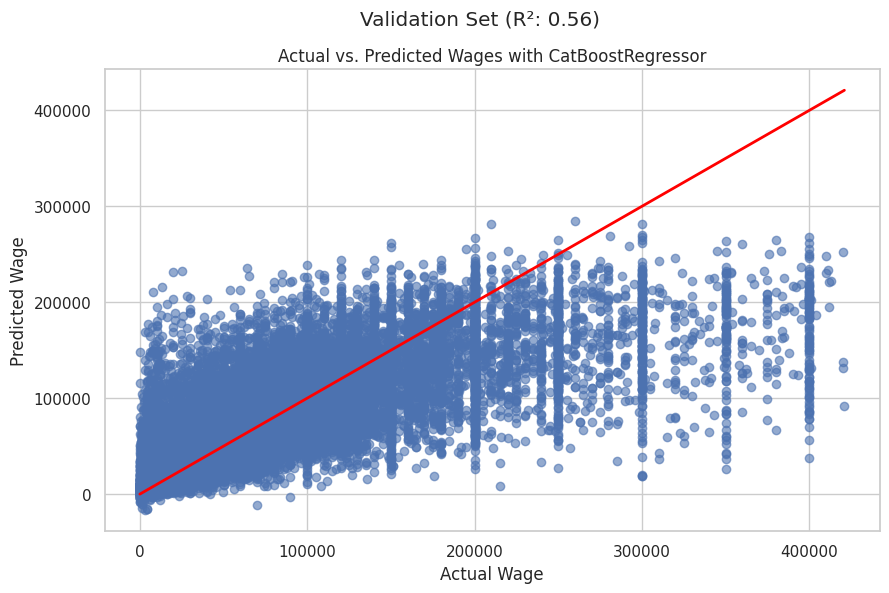

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()

These differences made a minimal difference on the MSE. The model is overfitting to the lower wages and is not able to generalize well to the higher wages.


###Approach #3:
#### Applying a Log Transformation to the Wage variable
Trying to transform the target variable to improve model performance. If we use the log of the y_train in the model training and then convert the results back, this may improve model performance.  

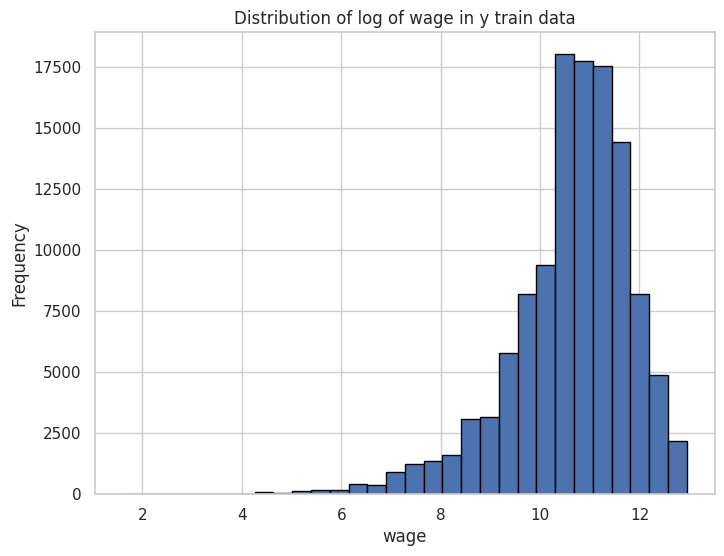

In [ ]:
# Checking the distribution of the log of wage
target_col = 'wage'
plt.figure(figsize=(8, 6))
# Drop missing values to avoid plotting issues
plt.hist(np.log1p(y_train.dropna()), bins=30, edgecolor='black')
plt.title(f'Distribution of log of {target_col} in y train data')
plt.xlabel(target_col)
plt.ylabel('Frequency')
plt.show()

In [ ]:
%%time
# Transform the target variable with log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

# Initialize the CatBoostRegressor with learning rate, depth and iterations for baseline
catboost_reg = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=5, random_state=123, verbose=0)

# Train the baseline model
catboost_reg.fit(X_train, y_train_log, cat_features=cat_columns, eval_set=(X_val, y_val_log))

# Make baseline predictions
y_val_pred_log = catboost_reg.predict(X_val)
y_val_pred = np.expm1(y_val_pred_log)

# Check the mse and r2
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Validation Set Mean Squared Error: 2189075416.98
Validation Set R-squared (R²): 0.52


Predicting the log of the training data did not improve the model.

### Approach #4
#### Undersampling the dataset to even out the amount of data for the wages
The model is overfitting the lower wage predictors and is not able to generalize well to the higher class. This may be due to the class imbalance. I will aim to improve the model by evening out the classes and emphasize high-wage observations.

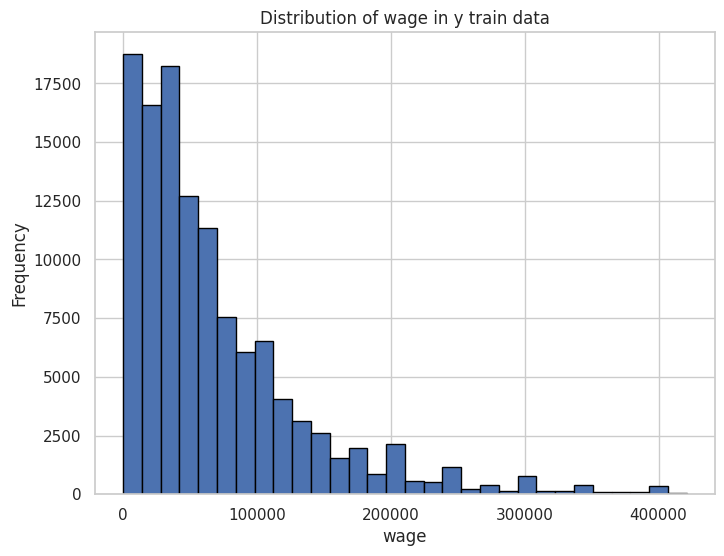

In [ ]:
# Check for Class Imbalances
target_col = 'wage'

plt.figure(figsize=(8, 6))
# Drop missing values to avoid plotting issues
plt.hist(y_train.dropna(), bins=30, edgecolor='black')
plt.title(f'Distribution of {target_col} in y train data')
plt.xlabel(target_col)
plt.ylabel('Frequency')
plt.show()


In [ ]:
def remove_top_5_percent(df, target_feature):
    """
    Removes the top 5% of values from the specified target feature in a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    target_feature (str): The column name of the target feature.

    Returns:
    pd.DataFrame: A new DataFrame with the top 5% of values removed.
    """
    threshold = df[target_feature].quantile(0.95)  # Calculate 95th percentile
    return df[df[target_feature] <= threshold]  # Keep only values below the threshold

data = remove_top_5_percent(data, 'wage')
print(f"The length of the data is {len(data)}.")

The length of the data is 169943.


<ipython-input-33-6674a81196c6>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_undersampled = data_copy.groupby('wage_bin', group_keys=False).apply(undersample_bin)


Text(0, 0.5, 'Frequency')

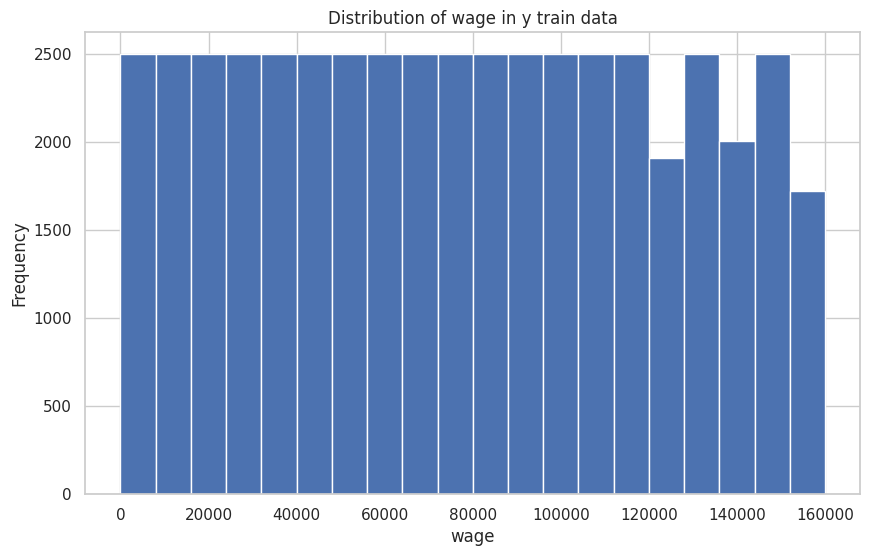

In [ ]:
n_bins = 20

# Create bin edges and assign each row to a bin
bins = np.linspace(data['wage'].min(), data['wage'].max(), n_bins + 1)
data_copy = data.copy()
data_copy['wage_bin'] = pd.cut(data_copy['wage'], bins=bins, labels=False, include_lowest=True)

# Keeping 2500 samples per bin
max_samples_per_bin = 2500

# Undersample each bin to make the distribution more even
def undersample_bin(bin_df):
    return bin_df.sample(n=min(len(bin_df), max_samples_per_bin), random_state=42)

df_undersampled = data_copy.groupby('wage_bin', group_keys=False).apply(undersample_bin)

# 5. (Optional) Remove the temporary bin column
df_undersampled.drop(columns='wage_bin', inplace=True)

# Check the distribution after undersampling
df_undersampled['wage'].hist(bins=n_bins, figsize=(10, 6))
plt.title(f'Distribution of {target_col} in y train data')
plt.xlabel(target_col)
plt.ylabel('Frequency')


### Redoing the data splits with the undersampled data

In [ ]:
# Define target variable and drop from dataset and split data
y_under = df_undersampled['wage']
X_under = df_undersampled.drop('wage', axis=1)

shuffled_indices = np.random.permutation(len(X_under))
X_under = X_under.iloc[shuffled_indices]
y_under = y_under.iloc[shuffled_indices]

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=1234)
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under, y_train_under, test_size=0.2, random_state=1234)


In [ ]:
%%time
# Define categorical features
cat_columns = ['housing_unit', 'person_number', 'worker_class',
       'educational_attainment', 'sex', 'num_hours_worked',
       'employment_status', 'industry', 'race_nohispanic', 'hispanic',
       'industry_recode', 'occupation_recode', 'dsengin_indicator',
       'dsengin_related_indicator', 'race', 'num_hours_worked_binned']

# Initialize the CatBoostRegressor with learning rate, depth and iterations for baseline
catboost_reg = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=5, random_state=123, verbose=0)

# Train the model
catboost_reg.fit(X_train_under, y_train_under, cat_features=cat_columns, eval_set=(X_val, y_val))

# Make predictions
y_val_pred_under = catboost_reg.predict(X_val_under)

# Check the mse and r2
mse = mean_squared_error(y_val_under, y_val_pred_under)
r2 = r2_score(y_val_under, y_val_pred_under)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Validation Set Mean Squared Error: 1327015963.56
Validation Set R-squared (R²): 0.59
CPU times: user 1min 28s, sys: 1.22 s, total: 1min 30s
Wall time: 59.8 s


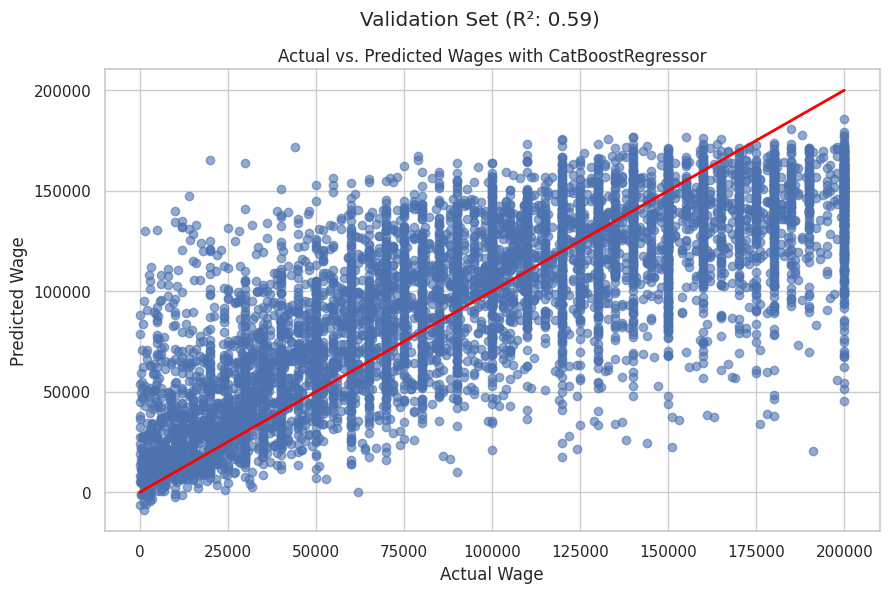

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val_under, y_val_pred_under, alpha=0.6)
plt.plot([min(y_val_under), max(y_val_under)], [min(y_val_under), max(y_val_under)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()

Undersampling does improve the model by about 3%. Now that the dataset is reduced, I can rerun the model but with finetuned parameters to find the optimal ones.

### Approach #5:
Using Grid Search on the undersampled data to try to beat 0.58 R^2

In [ ]:
print(f"The length of X_train is {len(X_train_under)}.")
print(f"The length of X_val is {len(X_val_under)}.")

The length of X_train is 29846.
The length of X_val is 7462.


In [ ]:
#%%time

cat_columns = ['housing_unit', 'person_number', 'worker_class',
       'educational_attainment', 'sex', 'num_hours_worked',
       'employment_status', 'industry', 'race_nohispanic', 'hispanic',
       'industry_recode', 'occupation_recode', 'dsengin_indicator',
       'dsengin_related_indicator', 'race', 'num_hours_worked_binned']

# Initialize the CatBoostRegressor
catboost_reg = CatBoostRegressor(random_state=123, verbose=0, early_stopping_rounds=50)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.05, 0.1],
    'depth': [5, 7],
    'iterations': [500, 700],
    'l2_leaf_reg': [1, 3, 5]
}

# Set up GridSearchCV
grid_search1 = GridSearchCV(
    estimator=catboost_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # using MSE as the scoring metric (negated by scikit-learn)
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV; pass the categorical features for CatBoost to handle them natively.
grid_search1.fit(X_train_under, y_train_under, cat_features=cat_columns)

# Best parameters found
print("Best parameters:", grid_search1.best_params_)

# Evaluate the best model on the val set
best_model = grid_search1.best_estimator_
y_val_pred_under = best_model.predict(X_val_under)

# Check the mse and r2
mse = mean_squared_error(y_val_under, y_val_pred_under)
r2 = r2_score(y_val_under, y_val_pred_under)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'depth': 7, 'iterations': 700, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
Validation Set Mean Squared Error: 862119911.52
Validation Set R-squared (R²): 0.58


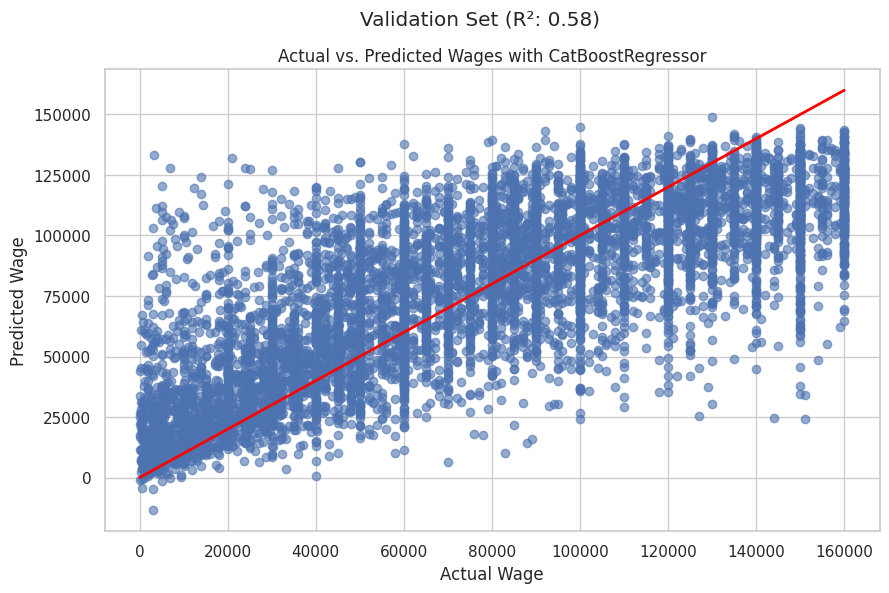

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val_under, y_val_pred_under, alpha=0.6)
plt.plot([min(y_val_under), max(y_val_under)], [min(y_val_under), max(y_val_under)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()

In [ ]:
# Evaluate the best model on the test set
y_test_pred_under = best_model.predict(X_test_under)

# Check the mse and r2
mse = mean_squared_error(y_test_under, y_test_pred_under)
r2 = r2_score(y_test_under, y_test_pred_under)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Validation Set Mean Squared Error: 831181056.17
Validation Set R-squared (R²): 0.60


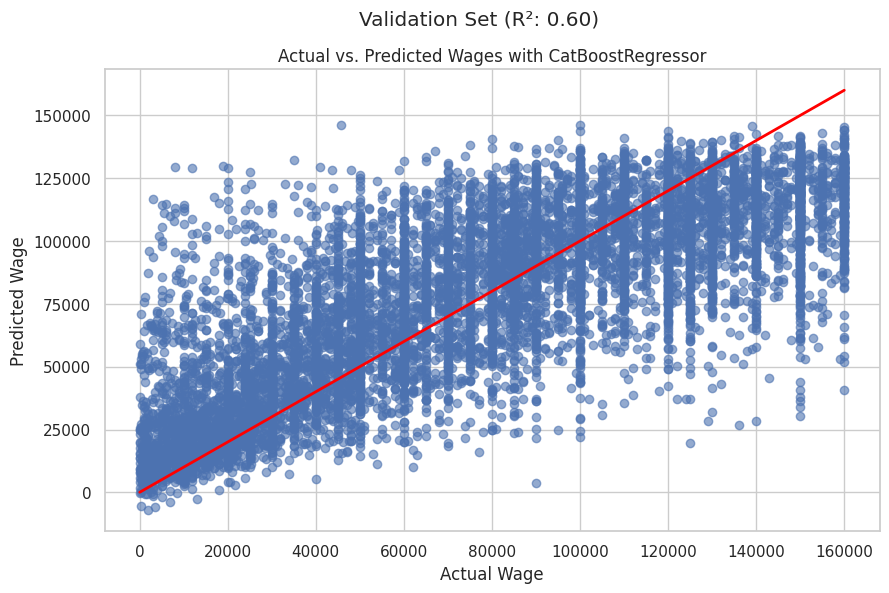

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_under, y_test_pred_under, alpha=0.6)
plt.plot([min(y_test_under), max(y_test_under)], [min(y_test_under), max(y_test_under)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()

In [ ]:
# Saving grid search results to drive
pd.DataFrame(grid_search1.cv_results_)[['params', 'mean_test_score', 'rank_test_score']].to_csv('/content/drive/My Drive/my_dataframe_final.csv', index=False)

### Approach #6
Adding in encodings to the categorical data with text

In [ ]:
worker_class = data[['worker_class']]
worker_class_binned = tf.keras.layers.StringLookup(vocabulary=sorted(data['worker_class'].unique()), mask_token=None)(worker_class)
worker_class_binned_emb = tf.keras.layers.Embedding(input_dim=len(data['worker_class'].unique())+1, output_dim=3)(worker_class_binned)

educational_attainment = data[['educational_attainment']]
educational_attainment_binned = tf.keras.layers.StringLookup(vocabulary=sorted(data['educational_attainment'].unique()), mask_token=None)(educational_attainment)
educational_attainment_binned_emb = tf.keras.layers.Embedding(input_dim=len(data['educational_attainment'].unique())+1, output_dim=3)(educational_attainment_binned)

sex = data[['sex']]
sex_binned = tf.keras.layers.StringLookup(vocabulary=sorted(data['sex'].unique()), mask_token=None)(sex)
sex_binned_emb = tf.keras.layers.Embedding(input_dim=len(data['sex'].unique())+1, output_dim=3)(sex_binned)


data['housing_unit'] = data['housing_unit'].astype('category').cat.codes.astype(int)
housing_unit = data[['housing_unit']]
housing_unit_binned_emb = tf.keras.layers.Embedding(input_dim=len(data['housing_unit'].unique())+1, output_dim=3)(housing_unit)

In [ ]:
data_embedding = tf.concat([worker_class_binned_emb, educational_attainment_binned_emb, sex_binned_emb, housing_unit_binned_emb], axis=1)
data_embedding = tf.keras.layers.Flatten()(data_embedding)


In [ ]:
# Convert the embedding tensor to a NumPy array
embedding_np = data_embedding.numpy()  # shape: (num_samples, embedding_dim)

#  Create a DataFrame
embedding_dim = embedding_np.shape[1]
embedding_columns = [f"embedding_{i}" for i in range(embedding_dim)]
embedding_df = pd.DataFrame(embedding_np, columns=embedding_columns)

# Remove the original categorical columns from data
data_copy = data.copy()
data_copy = data_copy.drop(columns=["worker_class", "educational_attainment", "sex", "housing_unit"], errors='ignore')

#  Concatenate the new embedding DataFrame with your original DataFrame
data_copy.reset_index(drop=True, inplace=True)
embedding_df.reset_index(drop=True, inplace=True)
data_with_embedding = pd.concat([data_copy, embedding_df], axis=1)

# Check shape of embeddings df
data_with_embedding.shape


(177800, 27)

<ipython-input-23-e3e85a890aff>:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_undersampled_embedding = data_with_embedding.groupby('wage_bin', group_keys=False).apply(undersample_bin)


<Axes: >

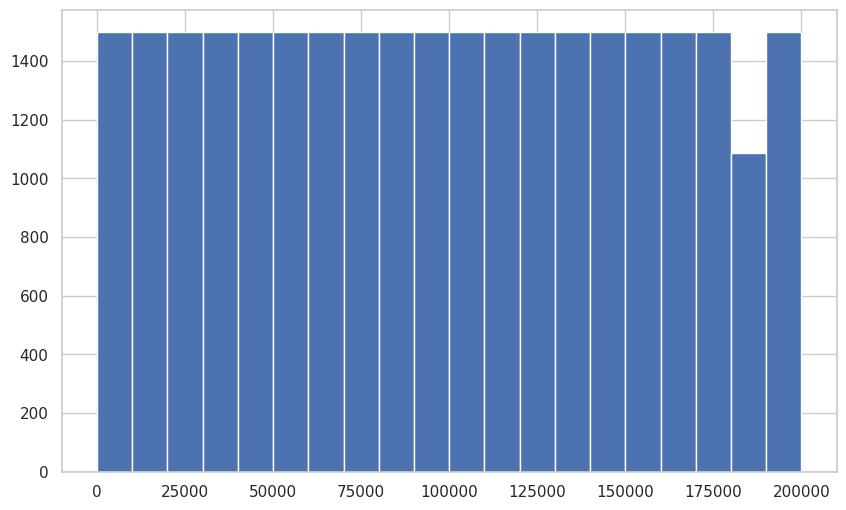

In [ ]:
# binning
n_bins = 20

# Create bin edges and assign each row to a bin
bins = np.linspace(data_with_embedding['wage'].min(), data['wage'].max(), n_bins + 1)
data_with_embedding['wage_bin'] = pd.cut(data_with_embedding['wage'], bins=bins, labels=False, include_lowest=True)

# Decide how many samples to keep per bin
max_samples_per_bin = 1500

# Undersample each bin to make the distribution more even
def undersample_bin(bin_df):
    return bin_df.sample(n=min(len(bin_df), max_samples_per_bin), random_state=42)

df_undersampled_embedding = data_with_embedding.groupby('wage_bin', group_keys=False).apply(undersample_bin)

# 5. (Optional) Remove the temporary bin column
df_undersampled_embedding.drop(columns='wage_bin', inplace=True)

# Check the distribution after undersampling
df_undersampled_embedding['wage'].hist(bins=n_bins, figsize=(10, 6))

In [ ]:
# Define target variable and drop from dataset and split data
y_under = df_undersampled_embedding['wage']
X_under = df_undersampled_embedding.drop('wage', axis=1)

shuffled_indices = np.random.permutation(len(X_under))
X_under = X_under.iloc[shuffled_indices]
y_under = y_under.iloc[shuffled_indices]

X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(X_under, y_under, test_size=0.2, random_state=1234)
X_train_under, X_val_under, y_train_under, y_val_under = train_test_split(X_train_under, y_train_under, test_size=0.2, random_state=1234)


In [ ]:
%%time
# Define categorical features
cat_columns = ['person_number', 'employment_status', 'industry', 'race_nohispanic', 'hispanic',
       'industry_recode', 'occupation_recode', 'dsengin_indicator',
       'dsengin_related_indicator', 'race', 'num_hours_worked_binned']

# Initialize the CatBoostRegressor with learning rate, depth and iterations for baseline
catboost_reg = CatBoostRegressor(random_state=123, verbose=0, early_stopping_rounds=50)

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [5, 7],
    'iterations': [500, 700],
    'l2_leaf_reg': [1, 3, 5]
}

# Set up GridSearchCV
grid_search1 = GridSearchCV(
    estimator=catboost_reg,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # using MSE as the scoring metric (negated by scikit-learn)
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV; pass the categorical features for CatBoost to handle them natively.
grid_search1.fit(X_train_under, y_train_under, cat_features=cat_columns)

# Best parameters found
print("Best parameters:", grid_search1.best_params_)

# Evaluate the best model on the test set
best_model = grid_search1.best_estimator_
y_val_pred_under = best_model.predict(X_val_under)

# Train the model
#catboost_reg.fit(X_train_under, y_train_under, cat_features=cat_columns, eval_set=(X_val_under, y_val_under))

# Make predictions
#y_val_pred_under = catboost_reg.predict(X_val_under)

# Check the mse and r2
mse = mean_squared_error(y_val_under, y_val_pred_under)
r2 = r2_score(y_val_under, y_val_pred_under)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters: {'depth': 7, 'iterations': 700, 'l2_leaf_reg': 5, 'learning_rate': 0.05}
Validation Set Mean Squared Error: 1374374189.64
Validation Set R-squared (R²): 0.59
CPU times: user 1min 30s, sys: 5.07 s, total: 1min 35s
Wall time: 41min 44s


In [ ]:
# Print out grid
cv_results_final = grid_search1.cv_results_

In [ ]:
pd.DataFrame(cv_results_final)[['params', 'mean_test_score', 'rank_test_score']].to_csv('/content/drive/My Drive/my_dataframe.csv', index=False)

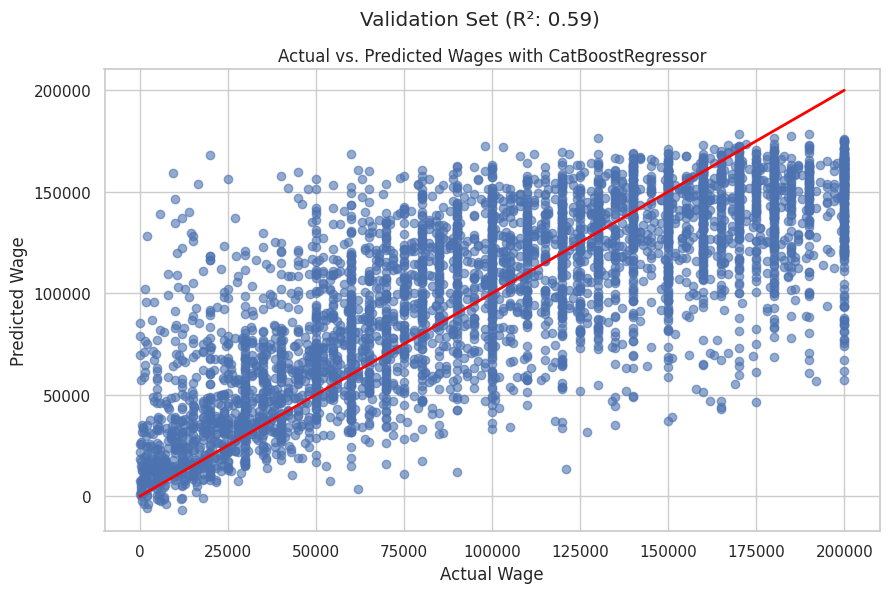

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val_under, y_val_pred_under, alpha=0.6)
plt.plot([min(y_val_under), max(y_val_under)], [min(y_val_under), max(y_val_under)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()

# Running the final model on the Test Data Set



In [ ]:
# Make predictions
y_test_pred_under = best_model.predict(X_test_under)

# Check the mse and r2
mse = mean_squared_error(y_test_under, y_test_pred_under)
r2 = r2_score(y_test_under, y_test_pred_under)
print(f"Validation Set Mean Squared Error: {mse:.2f}")
print(f"Validation Set R-squared (R²): {r2:.2f}")

Validation Set Mean Squared Error: 1360323028.83
Validation Set R-squared (R²): 0.59


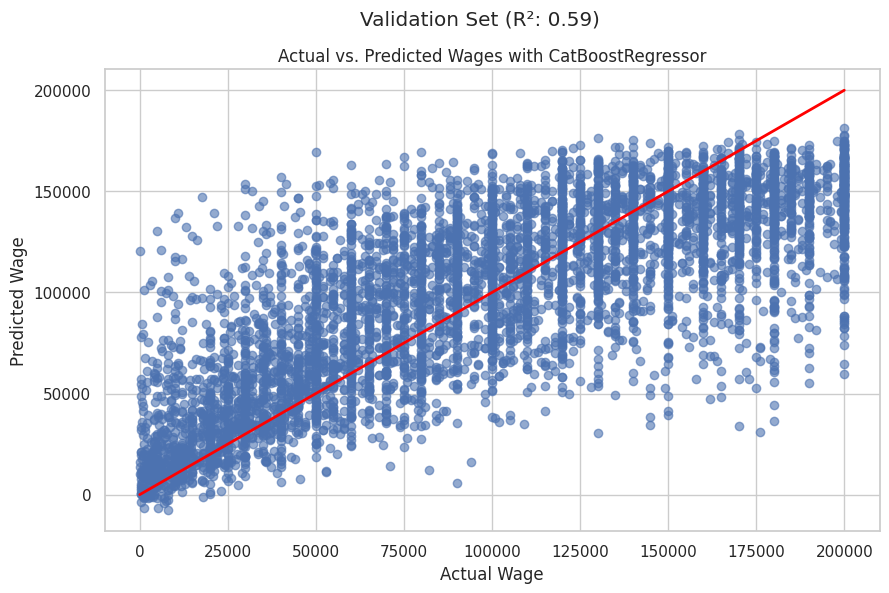

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_under, y_test_pred_under, alpha=0.6)
plt.plot([min(y_test_under), max(y_test_under)], [min(y_test_under), max(y_test_under)], color='red', lw=2)  # Diagonal reference line
plt.title('Actual vs. Predicted Wages with CatBoostRegressor')
plt.suptitle(f'Validation Set (R²: {r2:.2f})')
plt.xlabel('Actual Wage')
plt.ylabel('Predicted Wage')
plt.grid(True)
plt.show()